# Exploring r/redpillwomen submisions and comments

## Libraries & Setup

### Install

In [1]:
%pip install pandas numpy==1.24 matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install bertopic #[spacy]

Note: you may need to restart the kernel to use updated packages.


In [4]:
# %pip install NewsSentiment

In [5]:
%pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.


### Imports

In [6]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [7]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/.venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/.venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tilmankerl/Documents/

In [8]:
# Use a pipeline as a high-level helper
from transformers import pipeline

### General configs

In [9]:
# matplotlib theme
plt.style.use('ggplot')

### Data loading

In [10]:
# get DATA_DIR
DATA_DIR = os.path.join(Path(os.path.abspath("")).parent, "data")
print(DATA_DIR)

/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/data


In [11]:
submission_redpill = pd.read_csv(
    f"{DATA_DIR}/submission_redpill_with_topic.csv",   
)
comments_redpill = pd.read_csv(
    f"{DATA_DIR}/output/RedPillWomen_comments.csv",
    names=["score", "date", "is_submitter", "author","link", "body"]
)

In [12]:
submission_redpill.columns

Index(['score', 'date', 'title', 'author_flair_text', 'link_flair_text',
       'locked', 'over_18', 'author', 'link', 'body', 'month', 'year',
       'month_year', 'date_ordinal', 'doc_text', 'topic', 'topic_label'],
      dtype='object')

In [13]:
# feature types
submission_redpill.date = pd.to_datetime(submission_redpill.date)
submission_redpill['year'] = submission_redpill['date'].dt.year
submission_redpill['month'] = submission_redpill['date'].dt.month

# topic & topic_label as categorical
submission_redpill['topic'] = submission_redpill['topic'].astype('category')
submission_redpill['topic_label'] = submission_redpill['topic_label'].astype('category')

In [14]:
print(
    submission_redpill.date.min(),
    submission_redpill.date.max()
)

2013-06-17 00:00:00 2022-12-31 00:00:00


### Model loading

In [15]:
topic_model = BERTopic.load("../models/redPillSubmissions-20")

emotions_pipe = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions")
sentiment_pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Which topics are successful in terms of upvotes and comments?

In [47]:
# mean score per to pic anf get the top 10 topics
top_topics = submission_redpill.groupby('topic_label')["score"].mean().sort_values(ascending=False)

In [48]:
top_topics.head()

topic_label
Baseline relationship issues        30.214900
Gender roles: Alpha/Beta            25.225468
Personal self improvement (rec.)    24.498480
Education and Carreer               24.409975
Self care (rec.)                    24.403780
Name: score, dtype: float64

<Axes: title={'center': 'Most popular topics on r/redpillwomen'}, xlabel='Average upvotes', ylabel='Topic'>

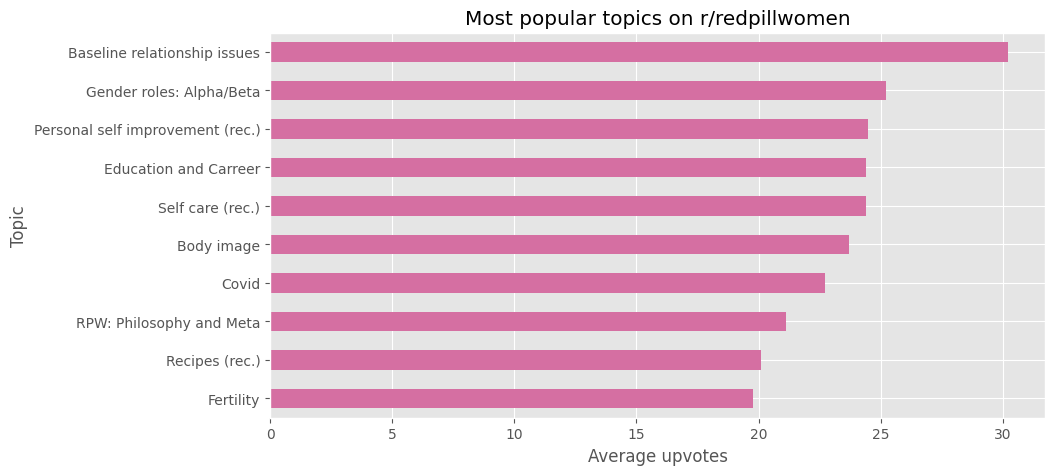

In [49]:
top_topics.sort_values(ascending=True).tail(10).plot.barh(
    figsize=(10, 5), 
    title='Most popular topics on r/redpillwomen',
    color='#d56fa2',
    legend=False,
    xlabel='Average upvotes',
    ylabel='Topic'
)

In [50]:
submission_redpill.to_csv('../data/submission_redpill_with_topic.csv', index=False)

## Preparing the data

We want to look at the sentiment and emotions of comments per topic, therefore we have to merge the submissions with the topic / append the topic to the comments. We will use the topic model from the previous notebook.

In [51]:
# Clean the comments body:
comments_redpill['body'] = comments_redpill['body'].str.replace('\n', ' ')
comments_redpill['body'] = comments_redpill['body'].str.replace('  ', ' ')

# set dtype to string
comments_redpill['body'] = comments_redpill['body'].astype(str)

# remove delted and removed posts
comments_redpill = comments_redpill[~comments_redpill['body'].str.contains('\[deleted\]|\[removed\]')]

In [52]:
comments_redpill.head()

,score,date,is_submitter,author,link,body
0,2,2017-10-01,False,u/etf42,https://www.reddit.com/r/RedPillWomen/comments...,Men have always been more disposable due to th...
1,1,2017-10-01,False,u/throwawayklutch,https://www.reddit.com/r/RedPillWomen/comments...,"To me, these women seem like they just have no..."
2,2,2017-10-01,False,u/SouthernAthena,https://www.reddit.com/r/RedPillWomen/comments...,That attitude will get them far in life. But y...
3,8,2017-10-01,False,u/platewrecked,https://www.reddit.com/r/RedPillWomen/comments...,"Greg the OP is a suicidal, drug addled, datele..."
4,2,2017-10-01,False,u/thelampshade25,https://www.reddit.com/r/RedPillWomen/comments...,Very funny video i was loling the whole time


In [ ]:
# first assign topic to each comment based on the link match to submission_redpill 
# join comments_redpill and submission_redpill on link
comments_redpill = comments_redpill.merge(submission_redpill[['link', 'topic']], on='link', how='left')

# drop rows where topic is NaN
comments_redpill = comments_redpill.dropna(subset=['topic'])

# make topic column an integer
comments_redpill['topic'] = comments_redpill['topic'].astype(int)

# filter comments that belong to topic -1
comments_redpill = comments_redpill[comments_redpill['topic'] != -1]

In [66]:
comments_redpill_docs = comments_redpill["body"].to_list()
# cut ofd comments after 512 words
comments_redpill_docs = [" ".join(comment.split(" ")[:500]) for comment in comments_redpill_docs]

In [68]:
print(len(comments_redpill_docs))

221107


## Sentiment per topic

In [70]:
comments_sentiments = sentiment_pipe(comments_redpill_docs[:1000],  max_length=512, truncation=True)

In [57]:
print(comments_sentiments)

[{'label': 'neutral', 'score': 0.7546858787536621}, {'label': 'negative', 'score': 0.7290244698524475}, {'label': 'negative', 'score': 0.4337417483329773}, {'label': 'negative', 'score': 0.9390236139297485}, {'label': 'positive', 'score': 0.9826751947402954}, {'label': 'neutral', 'score': 0.6590830087661743}, {'label': 'neutral', 'score': 0.5881479382514954}, {'label': 'negative', 'score': 0.5399062037467957}, {'label': 'negative', 'score': 0.5526711344718933}, {'label': 'negative', 'score': 0.9000615477561951}]


In [83]:
test = pd.read_csv(DATA_DIR + "/redpill_comments_topic_sentiment.csv")

/var/folders/0t/46569zhs0mng6tbft4v9wks40000gn/T/ipykernel_16454/3743867996.py:1: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(DATA_DIR + "/redpill_comments_topic_sentiment.csv")


In [84]:
test.shape

(164439, 9)

In [79]:
# count NAs for sentiment_label
print(test.shape)

test.sentiment_label.isna().sum()

(164439, 9)


87043